In [1]:
!unzip Brain_tumor_dataset.zip -d Brain_tumor_dataset

Streaming output truncated to the last 5000 lines.
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0712.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0713.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0714.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0715.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0716.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0717.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0718.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0719.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0720.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0721.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0722.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0723.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0724.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0725.jpg  
  inflating: Brain_tumor_

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import os


In [3]:
img_size = (224,224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.20,
    height_shift_range=0.20,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.85, 1.15],
    shear_range=0.15,
    fill_mode='nearest',
    validation_split=0.2
)





train_gen = train_datagen.flow_from_directory(
    "/content/Brain_tumor_dataset/Training",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset='training'
)


val_gen = train_datagen.flow_from_directory(
    "/content/Brain_tumor_dataset/Training",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    "/content/Brain_tumor_dataset/Testing",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [4]:

num_classes = 4


base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(img_size[0], img_size[1], 3)
)


base_model.trainable = False


inputs = layers.Input(shape=(img_size[0], img_size[1], 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)


outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)


model.compile(
    optimizer=Adam(learning_rate=3e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(name="precision"), Recall(name="recall")]
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
callbacks = [

    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),


    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=2,
        min_lr=1e-7
    ),


    ModelCheckpoint(
        "best_resnet50_brain_tumor.keras",
        monitor="val_loss",
        save_best_only=True
    )
]


In [6]:
epochs = 30

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 113s 688ms/step - accuracy: 0.2487 - loss: 1.8060 - precision: 0.2546 - recall: 0.1389 - val_accuracy: 0.2682 - val_loss: 1.3849 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 576ms/step - accuracy: 0.2726 - loss: 1.6596 - precision: 0.2805 - recall: 0.1316 - val_accuracy: 0.3567 - val_loss: 1.3403 - val_precision: 1.0000 - val_recall: 0.0053 - learning_rate: 3.0000e-05
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 590ms/step - accuracy: 0.3089 - loss: 1.5494 - precision: 0.3329 - recall: 0.1361 - val_accuracy: 0.3506 - val_loss: 1.3370 - val_precision: 0.9333 - val_recall: 0.0123 - learning_rate: 3.0000e-05
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 581ms/step - accuracy: 0.3229 - loss: 1.4909 - precision: 0.3821 - recall: 0.1411 - val_accuracy: 0.3576 - val_loss: 1.3275 - val_precision: 0.9333 - val_recall: 0.0245 - learning_rate: 3.0000e-05
Epoch 5/30
143/143 ━━━━━━━━

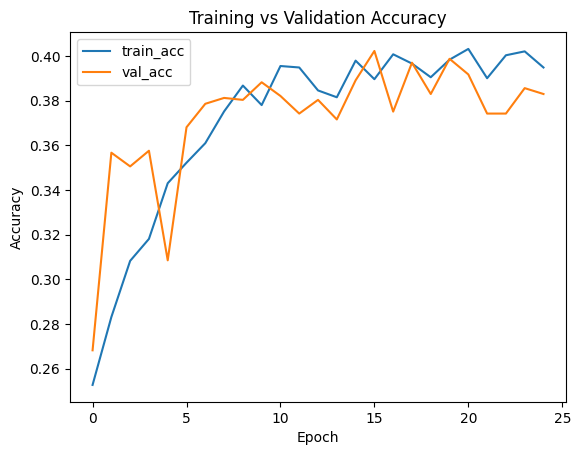

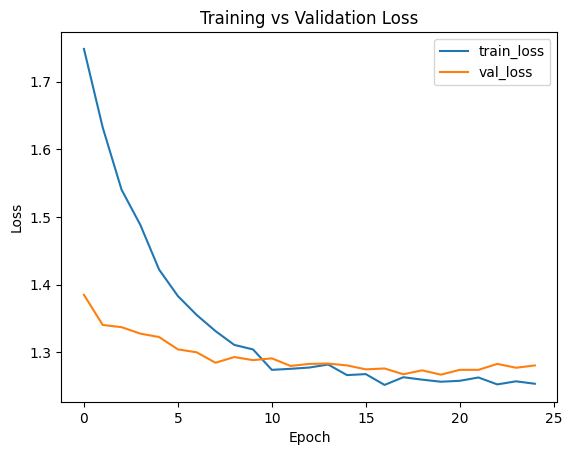

In [7]:
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [8]:
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_gen)
print(f"Test loss     : {test_loss:.4f}")
print(f"Test accuracy : {test_acc:.4f}")
print(f"Test precision: {test_prec:.44f}")
print(f"Test recall   : {test_rec:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.2317 - loss: 1.3780 - precision: 0.4101 - recall: 0.0683
Test loss     : 1.2012
Test accuracy : 0.4630
Test precision: 0.84210526943206787109375000000000000000000000
Test recall   : 0.1342


Class mapping: {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step


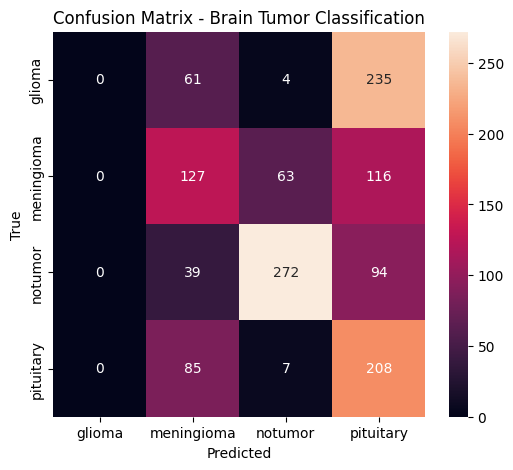

              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.41      0.42      0.41       306
     notumor       0.79      0.67      0.72       405
   pituitary       0.32      0.69      0.44       300

    accuracy                           0.46      1311
   macro avg       0.38      0.44      0.39      1311
weighted avg       0.41      0.46      0.42      1311



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


y_true = test_gen.classes


class_indices = test_gen.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

print("Class mapping:", idx_to_class)


y_prob = model.predict(test_gen)
y_pred = np.argmax(y_prob, axis=1)


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Brain Tumor Classification")
plt.show()


print(classification_report(y_true, y_pred, target_names=class_names))


In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from sklearn.utils import class_weight
import numpy as np


base_model = model.get_layer("resnet50")
base_model.trainable = True


for layer in base_model.layers:
    layer.trainable = False


N = 30
for layer in base_model.layers[-N:]:

    if "batch_normalization" in layer.name:
        layer.trainable = False
    else:
        layer.trainable = True


y_train = train_gen.classes

class_weights_array = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)


loss_fn = CategoricalCrossentropy(label_smoothing=0.03)

model.compile(
    optimizer=Adam(learning_rate=3e-6),
    loss=loss_fn,
    metrics=["accuracy", Precision(name="precision"), Recall(name="recall")]
)


history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weights
)


Class weights: {0: np.float64(1.0811258278145695), 1: np.float64(1.0659981343283582), 2: np.float64(0.8955721003134797), 3: np.float64(0.9800600343053173)}
Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 119s 687ms/step - accuracy: 0.2693 - loss: 5.8837 - precision: 0.2856 - recall: 0.2589 - val_accuracy: 0.2796 - val_loss: 2.8593 - val_precision: 0.2796 - val_recall: 0.2796 - learning_rate: 3.0000e-06
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 604ms/step - accuracy: 0.3831 - loss: 1.4772 - precision: 0.6936 - recall: 0.2122 - val_accuracy: 0.4216 - val_loss: 1.4492 - val_precision: 0.6890 - val_recall: 0.1262 - learning_rate: 3.0000e-06
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 581ms/step - accuracy: 0.4499 - loss: 1.2333 - precision: 0.8748 - recall: 0.1919 - val_accuracy: 0.4479 - val_loss: 1.2888 - val_precision: 0.7989 - val_recall: 0.1253 - learning_rate: 3.0000e-06
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 585ms/step - accuracy: 0.4841 - loss: 1.1571 - precision: 0.9037 - recall: 0

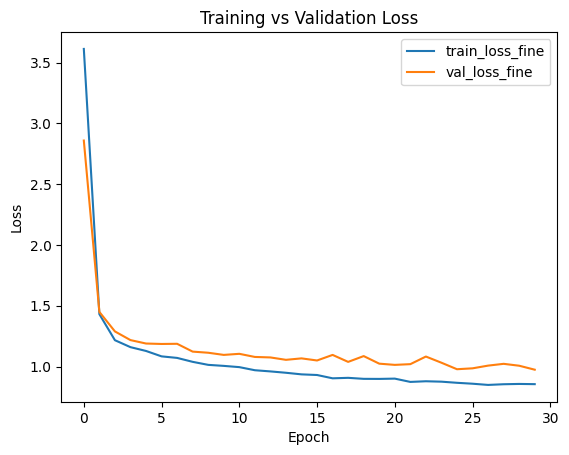

In [11]:
plt.plot(history_fine.history["loss"], label="train_loss_fine")
plt.plot(history_fine.history["val_loss"], label="val_loss_fine")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

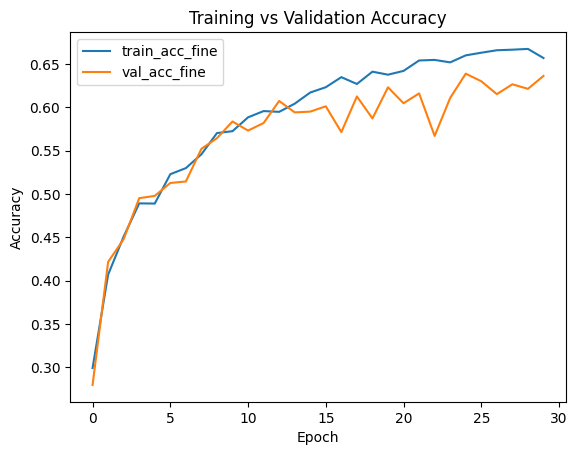

In [12]:
plt.plot(history_fine.history["accuracy"], label="train_acc_fine")
plt.plot(history_fine.history["val_accuracy"], label="val_acc_fine")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

In [13]:
model.save("resnet50_brain_tumor_good_baseline.keras")


In [14]:

from tensorflow.keras.losses import CategoricalCrossentropy
base_model.trainable = True
fine_tune_at = int(len(base_model.layers) * 0.6)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


loss_fn = CategoricalCrossentropy(label_smoothing=0.05)
model.compile(
    optimizer=Adam(learning_rate=5e-6),
    loss=loss_fn,
    metrics=["accuracy", Precision(name="precision"), Recall(name="recall")]
)

callbacks_deep = [
    EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-7),
    ModelCheckpoint("resnet50_brain_tumor_best_deep.keras",
                    monitor="val_loss", save_best_only=True)
]

history_deep = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks_deep
)


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 116s 685ms/step - accuracy: 0.6696 - loss: 0.8660 - precision: 0.7754 - recall: 0.5096 - val_accuracy: 0.6328 - val_loss: 1.0232 - val_precision: 0.7185 - val_recall: 0.4698 - learning_rate: 5.0000e-06
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 88s 616ms/step - accuracy: 0.6617 - loss: 0.8672 - precision: 0.7720 - recall: 0.4921 - val_accuracy: 0.6240 - val_loss: 1.0092 - val_precision: 0.7277 - val_recall: 0.4566 - learning_rate: 5.0000e-06
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 626ms/step - accuracy: 0.6700 - loss: 0.8765 - precision: 0.7737 - recall: 0.5040 - val_accuracy: 0.6205 - val_loss: 0.9986 - val_precision: 0.7188 - val_recall: 0.4750 - learning_rate: 5.0000e-06
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 88s 618ms/step - accuracy: 0.6637 - loss: 0.8645 - precision: 0.7815 - recall: 0.5100 - val_accuracy: 0.6293 - val_loss: 0.9798 - val_precision: 0.7333 - val_recall: 0.5110 - learning_rate: 5.0000e-06
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━

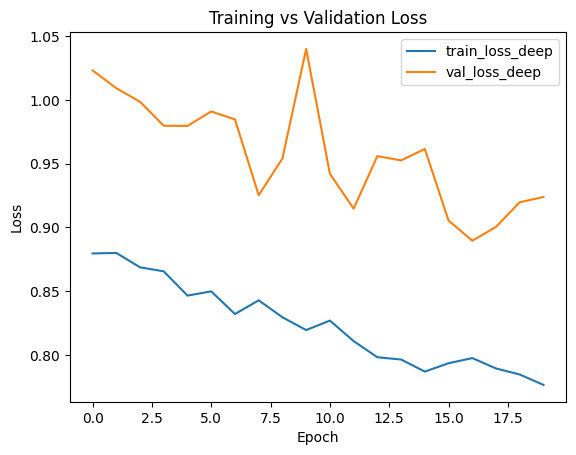

In [15]:
plt.plot(history_deep.history["loss"], label="train_loss_deep")
plt.plot(history_deep.history["val_loss"], label="val_loss_deep")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

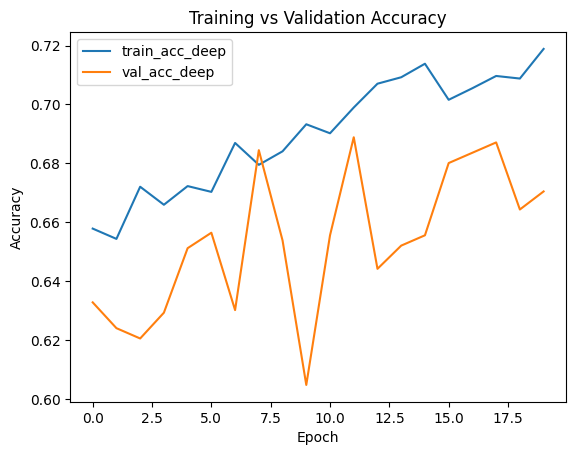

In [16]:
plt.plot(history_deep.history["accuracy"], label="train_acc_deep")
plt.plot(history_deep.history["val_accuracy"], label="val_acc_deep")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

In [17]:
import numpy as np
from sklearn.utils import class_weight


y_train = train_gen.classes

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.0811258278145695), 1: np.float64(1.0659981343283582), 2: np.float64(0.8955721003134797), 3: np.float64(0.9800600343053173)}


In [18]:
history_weighted = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks_deep,
    class_weight=class_weights
)


Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 104s 639ms/step - accuracy: 0.7211 - loss: 0.8004 - precision: 0.8048 - recall: 0.5933 - val_accuracy: 0.6626 - val_loss: 0.9468 - val_precision: 0.7400 - val_recall: 0.5513 - learning_rate: 1.3500e-07
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 583ms/step - accuracy: 0.6965 - loss: 0.8247 - precision: 0.7696 - recall: 0.5852 - val_accuracy: 0.6722 - val_loss: 0.9272 - val_precision: 0.7535 - val_recall: 0.5627 - learning_rate: 1.3500e-07
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 576ms/step - accuracy: 0.7148 - loss: 0.8057 - precision: 0.7938 - recall: 0.5895 - val_accuracy: 0.6635 - val_loss: 0.9247 - val_precision: 0.7346 - val_recall: 0.5530 - learning_rate: 1.3500e-07
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 580ms/step - accuracy: 0.7021 - loss: 0.8181 - precision: 0.7871 - recall: 0.5827 - val_accuracy: 0.6810 - val_loss: 0.9161 - val_precision: 0.7595 - val_recall: 0.5758 - learning_rate: 1.3500e-07
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━

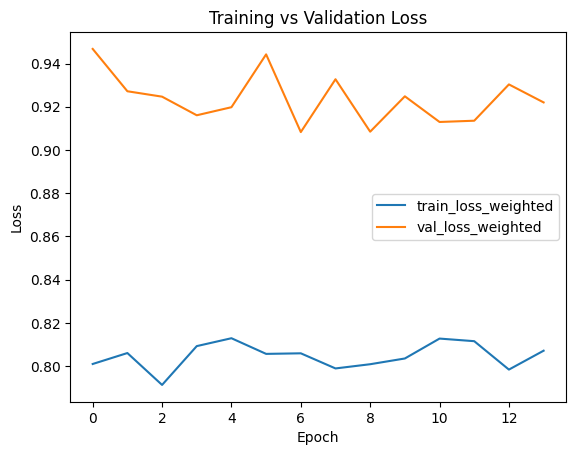

In [19]:
plt.plot(history_weighted.history["loss"], label="train_loss_weighted")
plt.plot(history_weighted.history["val_loss"], label="val_loss_weighted")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

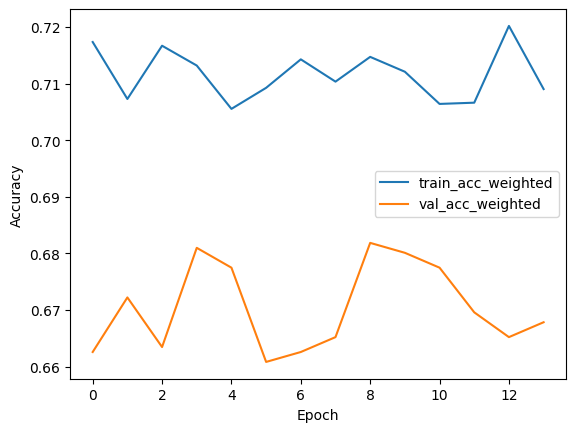

In [20]:
plt.plot(history_weighted.history["accuracy"], label="train_acc_weighted")
plt.plot(history_weighted.history["val_accuracy"], label="val_acc_weighted")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from google.colab import files   # remove if not using Colab

# Create folder for saving plots
plot_dir = "RestNet_plots"
os.makedirs(plot_dir, exist_ok=True)

def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # ---------------------- ACCURACY ----------------------
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, history_fine.history['accuracy'], label='Train Accuracy', linewidth=2.5)
    plt.plot(epochs, history_fine.history['val_accuracy'], label='Val Accuracy', linewidth=2.5)
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{plot_dir}/accuracy.png", dpi=200, bbox_inches='tight')
    plt.close()

    # ---------------------- LOSS ----------------------
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, history_fine.history['loss'], label='Train Loss', linewidth=2.5)
    plt.plot(epochs, history_fine.history['val_loss'], label='Val Loss', linewidth=2.5)
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{plot_dir}/loss.png", dpi=200, bbox_inches='tight')
    plt.close()

    # ---------------------- AUC ----------------------
    if "auc" in history.history:
        plt.figure(figsize=(8, 6))
        plt.plot(epochs, history_fine.history['auc'], label='Train AUC', linewidth=2.5)
        plt.plot(epochs, history_fine.history['val_auc'], label='Val AUC', linewidth=2.5)
        plt.title("Model AUC")
        plt.xlabel("Epoch")
        plt.ylabel("AUC")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(f"{plot_dir}/auc.png", dpi=200, bbox_inches='tight')
        plt.close()

    # ---------------------- GAP ANALYSIS ----------------------
    train_acc = np.array(history_fine.history['accuracy'])
    val_acc = np.array(history_fine.history['val_accuracy'])
    gap = train_acc - val_acc

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, gap, 'g-', label='Train-Val Gap', linewidth=2.5)
    plt.axhline(y=0.05, color='orange', linestyle='--', alpha=0.6, label='5% threshold')
    plt.axhline(y=0.10, color='red', linestyle='--', alpha=0.6, label='10% threshold')
    plt.title("Overfitting Gap Analysis")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy Gap")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{plot_dir}/gap_analysis.png", dpi=200, bbox_inches='tight')
    plt.close()

    print("\nAll plots saved in the 'plots/' folder!")

# Generate and save all plots
plot_training_history(history_fine)

# ---------------------- ZIP FOLDER ----------------------
zip_path = shutil.make_archive("RestNet_plots", 'zip', plot_dir)
print("ZIP file created:", zip_path)



All plots saved in the 'plots/' folder!
ZIP file created: /content/RestNet_plots.zip
